Let's first get all the roofs that have a roof:material OpenStreetMap(OSM) tag in Nepal. We will be using the Overpass API, which allows us to fetch data from OSM. More information about the Overpass API query language and other examples can be found here: https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_API_by_Example.

In [12]:
import overpy

api = overpy.Overpass()

# define query to get buildings with roof:material in Nepal, using the bounding box (26.347, 80.0585, 30.446, 88.2015)
# change the bounding box coordinates to get data from your desired study area (min latitude, min longitude, max latitude, max longitude)
query = """
[out:json][timeout:180];
(
  way["building"]["roof:material"](27.511307, 85.130253, 27.85288, 86.529824);
);
out body;
>;
out skel qt;
"""

response = api.query(query)

# extract building ids and roof materials
buildings = []
for way in response.ways:
    building = {
        "id": way.id,
        "roof_material": way.tags.get("roof:material", "unknown"),
        "geometry": [(float(node.lat), float(node.lon)) for node in way.nodes] #convert to float, because node.lon and node.lat are Decimal() objects by default
    }
    buildings.append(building)

# Oy
print(f"total buildings queried: {len(buildings)}")
print(f"first 4 buildings: {buildings[0:3]}")

total buildings queried: 17640
first 4 buildings: [{'id': 112551795, 'roof_material': 'metal', 'geometry': [(27.7102375, 85.3093988), (27.7103155, 85.3091665), (27.7102236, 85.3091271), (27.7102006, 85.3091955), (27.7100299, 85.3091224), (27.710057, 85.3090418), (27.7099343, 85.3089893), (27.7099089, 85.3090648), (27.7097037, 85.3089769), (27.7097221, 85.3089221), (27.7096405, 85.3088871), (27.7095682, 85.3091026), (27.7096532, 85.309139), (27.7096701, 85.3090887), (27.7098548, 85.3091677), (27.7098383, 85.3092166), (27.7099668, 85.3092716), (27.7099805, 85.3092309), (27.7101726, 85.3093131), (27.7101556, 85.3093637), (27.7102375, 85.3093988)]}, {'id': 120277868, 'roof_material': 'mixed', 'geometry': [(27.7165969, 85.3121085), (27.7166264, 85.3118218), (27.71661, 85.311798), (27.7165781, 85.3117935), (27.7165282, 85.3117865), (27.716532, 85.3117515), (27.7164593, 85.3117413), (27.7164383, 85.3119327), (27.7163399, 85.3119189), (27.7163325, 85.3120623), (27.7165969, 85.3121085)]}, {'id'

Next, we should convert the building geometries to a geopandas dataframe for future geospatial operations and to be able to better access/manipulate the data

In [13]:
import geopandas as gpd
from shapely.geometry import Polygon

# create a list of shapely Polygons with each building["geometry"] being a list of coordinates
geometries = [Polygon(building["geometry"]) for building in buildings]
roof_materials = [building["roof_material"] for building in buildings]

buildings_gdf = gpd.GeoDataFrame({"roof_material": roof_materials}, geometry=geometries)
buildings_gdf.crs = "EPSG:4326"

buildings_gdf.head()

,roof_material,geometry
0,metal,"POLYGON ((27.71024 85.3094, 27.71032 85.30917,..."
1,mixed,"POLYGON ((27.7166 85.31211, 27.71663 85.31182,..."
2,concrete,"POLYGON ((27.71302 85.31047, 27.71249 85.31049..."
3,concrete,"POLYGON ((27.70559 85.35044, 27.70553 85.35041..."
4,stone,"POLYGON ((27.6737 85.32491, 27.67358 85.32488,..."


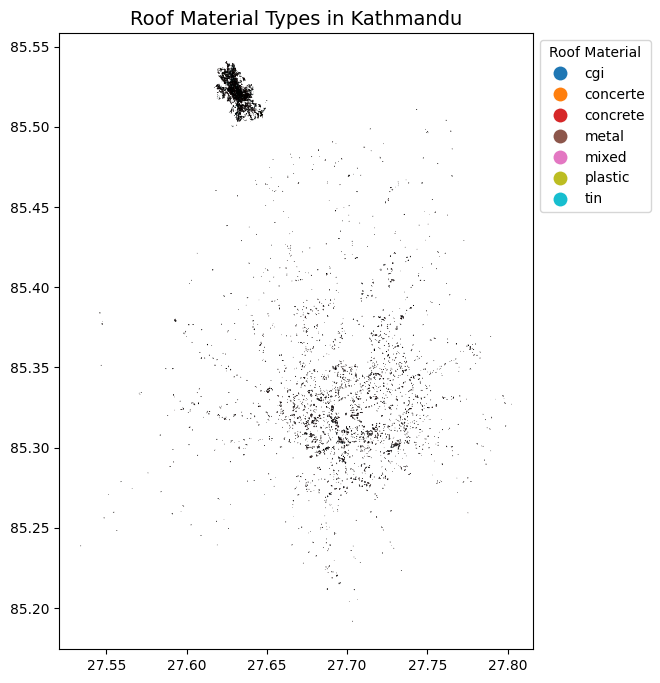

In [20]:
import matplotlib.pyplot as plt

material_counts = buildings_gdf['roof_material'].value_counts()
keep_materials = material_counts[material_counts > 200].index.tolist()
gdf_filtered = buildings_gdf[buildings_gdf['roof_material'].isin(keep_materials)]

fig, ax = plt.subplots(figsize=(10, 8))

gdf_filtered.plot(
    ax=ax,
    column="roof_material",
    legend=True,
    legend_kwds={
        "title": "Roof Material",
        "bbox_to_anchor": (1, 1),
        "loc": "upper left"
    },
    edgecolor="black",
    linewidth=0.3,
    cmap="tab10"
)
# ax.set_xlim(85.25, 85.6)
# ax.set_ylim(27.6, 27.8)
ax.set_aspect('equal')
ax.set_title("Roof Material Types in Kathmandu", fontsize=14)

plt.show()